In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
sns.set_style("whitegrid")
import warnings

In [2]:
nikkei=pd.read_csv('data/nikkei_225_data.csv')

In [3]:
nikkei.head()

,Date,datetime,Open,High,Low,Close
0,1985-03-25,1985-03-25,12526.09,12535.10,12479.03,12493.26
1,1985-03-26,1985-03-26,12473.34,12486.15,12448.10,12486.15
2,1985-03-27,1985-03-27,12484.46,12551.77,12483.50,12550.82
3,1985-03-28,1985-03-28,12595.35,12611.17,12575.90,12604.02
4,1985-03-29,1985-03-29,12613.27,12622.62,12567.32,12580.76


In [6]:
def custom_time_indexing(df, date_column):
    """
    Function to reindex a DataFrame with a custom index that reflects gaps in a time series,
    while keeping the original date column for plotting, without modifying the original DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    date_column (str): Name of the column containing datetime objects.

    Returns:
    pd.DataFrame: A new DataFrame with the custom index reflecting date gaps,
                  while retaining the original dates in a new column.
    list: A list of the original date labels corresponding to valid data rows.
    """
    # Work on a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Ensure the date_column is of datetime type
    df_copy[date_column] = pd.to_datetime(df_copy[date_column])

    # Set the date column as the index
    df_copy.set_index(date_column, inplace=True)

    # Generate the full date range (including missing dates)
    full_range = pd.date_range(start=df_copy.index.min(), end=df_copy.index.max())

    # Reindex the DataFrame to include the full range of dates
    df_reindexed = df_copy.reindex(full_range)

    # Create a custom index that increments by 1, but jumps when there are missing dates
    custom_index = []
    current_index = 1

    for i in range(len(df_reindexed)):
        if i == 0:
            custom_index.append(current_index)
        else:
            # Check if the current date is consecutive to the previous one
            if df_reindexed.index[i] - df_reindexed.index[i-1] > timedelta(days=1):
                # Increase the custom index by the actual day difference
                current_index += (df_reindexed.index[i] - df_reindexed.index[i-1]).days
            else:
                current_index += 1
            custom_index.append(current_index)

    # Assign the custom index to the DataFrame
    df_reindexed['custom_index'] = custom_index

    # Drop the rows where there are missing values
    df_final = df_reindexed.dropna()

    # Add the original date index as a new column and make it a datetime object
    df_final['date_time'] = df_final.index
    df_final['date_time']=df_final['date_time'].apply(lambda day: day.date())

    # Set the new custom index
    df_final.set_index('custom_index', inplace=True)

    # Return the final DataFrame and the valid original dates
    return df_final, df_final['date_time']


In [7]:
def linspace_dates(df,num_ticks):
    # because of missing dates, we have to do some annoying stuff there are about 14000 days between the first
    # and last day for UNP but some dates are skipped and so we have only 9400 or so datapoints
    # to properly plot, we will get some evenly spaced segments and then get the correct corresponding days

    start_date = df.loc[1]['date_time']
    end_date = df.tail(1)['date_time']
    
    # Calculate the total number of days in the range
    total_days = (end_date - start_date).values[0].days

    # Number of segments
    num_segments = num_ticks-1 # one less than the number of ticks desired

    # Calculate the length of each segment in days
    segment_length = total_days / num_segments

    # Create a list to hold the tick mark dates
    tick_dates = []

    # Calculate the dates for each tick mark
    for i in range(num_segments + 1):
        tick_date = start_date + timedelta(days=segment_length * i)
        tick_dates.append(tick_date)

    # Convert tick_dates to a list of strings for labeling
    tick_labels = [date.strftime('%Y-%m-%d') for date in tick_dates]

    # return the tick dates and labels
    return tick_dates, tick_labels


In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Ignore all warnings
    nikkei_reindex,valid_dates = custom_time_indexing(nikkei, 'datetime')

In [9]:
nikkei_tick_dates, nikkei_tick_labels = linspace_dates(nikkei_reindex,10) 
# remember, the labels begin and end on the dates where we have available data for WFC

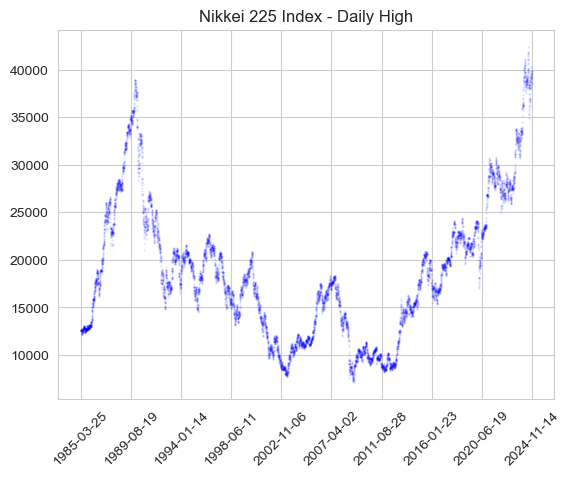

In [14]:
# we can plot Nikkei 225 now with the missing dates, it seems to know to plot the years on the x-axis now
# the issue is that it's not correctly spaced; the skips in time might not always be the same amount
#plt.plot(df_UNP.index,df_UNP['high'],label='Union Pacific - transportation',alpha=0.4)

plt.scatter(nikkei_reindex.index,nikkei_reindex['High'],label='High',color='b',alpha=0.1,s=0.4)

plt.title('Nikkei 225 Index - Daily High')

num_entries = nikkei_reindex.index.max()

# Set a desired number of ticks; in the cell above, we had num_segments = 9 (one less than num_ticks)
num_ticks = 10

# Generate equally spaced tick positions
nikkei_tick_positions = np.linspace(0, num_entries - 1, num_ticks).astype(int)

# Set the ticks and their corresponding labels from the original dates
plt.xticks(ticks=nikkei_tick_positions, labels=nikkei_tick_labels, rotation=45)

# Set x-axis limits to span the full range of the custom index
#plt.xlim(df_UNP_reindex.index.min(), df_UNP_reindex.index.max())

#plt.legend()
plt.show()

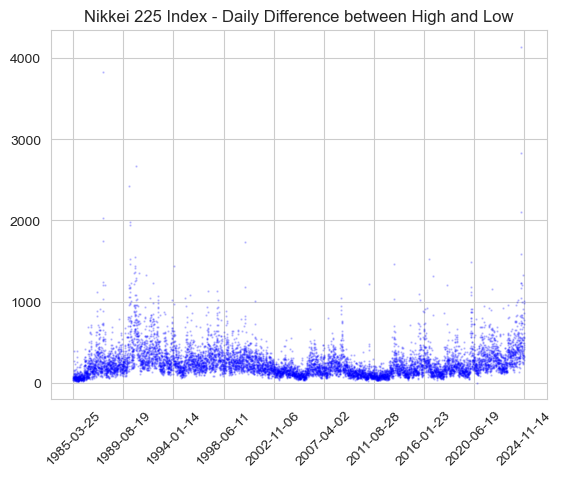

In [16]:
# we can plot Nikkei 225 now with the missing dates, it seems to know to plot the years on the x-axis now
# the issue is that it's not correctly spaced; the skips in time might not always be the same amount

plt.scatter(nikkei_reindex.index,nikkei_reindex['High']-nikkei_reindex['Low'],label='Difference',color='b',alpha=0.2,s=0.5)

plt.title('Nikkei 225 Index - Daily Difference between High and Low')

num_entries = nikkei_reindex.index.max()

# Set a desired number of ticks; in the cell above, we had num_segments = 9 (one less than num_ticks)
num_ticks = 10

# Generate equally spaced tick positions
nikkei_tick_positions = np.linspace(0, num_entries - 1, num_ticks).astype(int)

# Set the ticks and their corresponding labels from the original dates
plt.xticks(ticks=nikkei_tick_positions, labels=nikkei_tick_labels, rotation=45)


#plt.legend()
plt.show()

### Getting weekends; it seems we need to convert the datetime column into datetime objects again.

In [6]:
nikkei['datetime'] = pd.to_datetime(nikkei['datetime'], errors='coerce')

In [7]:
nikkei.iloc[0]['datetime']

Timestamp('1985-03-25 00:00:00')

In [12]:
# Filter for Fridays and Mondays
filtered_nikkei = nikkei[nikkei['datetime'].dt.dayofweek.isin([0, 4])]

# Create a new column 'DayType' indicating 'Monday' or 'Friday'
filtered_nikkei['DayType'] = np.where(filtered_nikkei['datetime'].dt.dayofweek == 0, 'Monday', 'Friday')

/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_19465/2717809335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nikkei['DayType'] = np.where(filtered_nikkei['datetime'].dt.dayofweek == 0, 'Monday', 'Friday')


In [14]:
nikkei=filtered_nikkei

In [16]:
# Initialize a list to store the valid rows
valid_rows = []

# Iterate through the group (stock data) to check Friday-Monday intervals
for i in range(len(nikkei) - 1):
    current_day = nikkei.iloc[i]['DayType']
    next_day = nikkei.iloc[i + 1]['DayType']
    current_date = nikkei.iloc[i]['datetime']
    next_date = nikkei.iloc[i + 1]['datetime']

    # Check if current day is Friday and next day is Monday
    if current_day == 'Friday' and next_day == 'Monday':
        # Calculate the difference in days
        days_diff = (next_date - current_date).days
        # If the difference is within 3 days, add both rows to the valid list
        if days_diff <= 3:
            valid_rows.append(nikkei.iloc[i])       # Add the Friday row
            valid_rows.append(nikkei.iloc[i + 1])   # Add the Monday row

# Create a new DataFrame from the valid rows
valid_pairs_df = pd.DataFrame(valid_rows).reset_index(drop=True)

# Output the new DataFrame
print(valid_pairs_df.head())
print(f"Total valid pairs: {len(valid_pairs_df) // 2}")

# Save the valid pairs to a CSV file
valid_pairs_df.to_csv("nikkei_valid_pairs.csv", index=False)
print("Filtered data with valid Friday-Monday pairs saved to 'nikkei_valid_pairs.csv'.")


         Date   datetime      Open      High       Low     Close DayType
0  1985-03-29 1985-03-29  12613.27  12622.62  12567.32  12580.76  Friday
1  1985-04-01 1985-04-01  12609.94  12677.15  12600.97  12677.15  Monday
2  1985-04-05 1985-04-05  12637.11  12643.78  12523.55  12544.24  Friday
3  1985-04-08 1985-04-08  12589.15  12635.96  12572.27  12635.96  Monday
4  1985-04-12 1985-04-12  12580.09  12592.68  12558.64  12588.01  Friday
Total valid pairs: 1753
Filtered data with valid Friday-Monday pairs saved to 'nikkei_valid_pairs.csv'.


In [17]:
valid_nikkei=pd.read_csv('nikkei_valid_pairs.csv')

In [21]:
# Initialize a list to store the combined rows
combined_rows = []

# Iterate through the valid pairs (step by 2 because each pair has a Friday and a Monday)
for i in range(0, len(valid_pairs_df), 2):
    # Get the Friday and Monday rows
    friday_row = valid_pairs_df.iloc[i]
    monday_row = valid_pairs_df.iloc[i + 1]

    # Combine the data into a single row (prefix columns with 'Friday_' and 'Monday_')
    combined_data = {
        'Friday_date': friday_row['datetime'],     # Friday date
        'Monday_date': monday_row['datetime'],     # Monday date
        'Friday_day': friday_row['DayType'],       # Should be 'Friday'
        'Monday_day': monday_row['DayType'],       # Should be 'Monday'
    }

    # Add all other columns, prefixing them with 'Friday_' or 'Monday_'
    for col in friday_row.index:
        if col not in ['datetime', 'DayType']:
            combined_data[f'Friday_{col}'] = friday_row[col]
            combined_data[f'Monday_{col}'] = monday_row[col]

    # Append the combined data to the list
    combined_rows.append(combined_data)

# Create a new DataFrame from the combined rows
combined_df = pd.DataFrame(combined_rows)

# Output the new DataFrame
print(combined_df.head())
print(f"New DataFrame shape: {combined_df.shape}")

# Save the combined DataFrame to a CSV file
combined_df.to_csv("nikkei_combined_pairs.csv", index=False)
print("Combined Friday-Monday pairs saved to 'nikkei_combined_pairs.csv'.")


  Friday_date Monday_date Friday_day Monday_day Friday_Date Monday_Date  \
0  1985-03-29  1985-04-01     Friday     Monday  1985-03-29  1985-04-01   
1  1985-04-05  1985-04-08     Friday     Monday  1985-04-05  1985-04-08   
2  1985-04-12  1985-04-15     Friday     Monday  1985-04-12  1985-04-15   
3  1985-04-19  1985-04-22     Friday     Monday  1985-04-19  1985-04-22   
4  1985-05-10  1985-05-13     Friday     Monday  1985-05-10  1985-05-13   

   Friday_Open  Monday_Open  Friday_High  Monday_High  Friday_Low  Monday_Low  \
0     12613.27     12609.94     12622.62     12677.15    12567.32    12600.97   
1     12637.11     12589.15     12643.78     12635.96    12523.55    12572.27   
2     12580.09     12597.16     12592.68     12618.99    12558.64    12552.73   
3     12040.90     12267.73     12152.84     12278.32    11996.00    12172.29   
4     12491.60     12569.12     12527.31     12571.80    12475.37    12531.32   

   Friday_Close  Monday_Close  
0      12580.76      12677.15 

In [22]:
combined_nikkei = pd.read_csv('nikkei_combined_pairs.csv')

In [25]:
# Drop the 'Friday_day' and 'Monday_day' columns
combined_nikkei.drop(columns=['Friday_day', 'Monday_day'], inplace=True)

In [29]:
combined_nikkei.drop(columns=['Friday_Date', 'Monday_Date'], inplace=True)

In [30]:
combined_nikkei.head(10)

,Friday_date,Monday_date,Friday_Open,Monday_Open,Friday_High,Monday_High,Friday_Low,Monday_Low,Friday_Close,Monday_Close
0,1985-03-29,1985-04-01,12613.27,12609.94,12622.62,12677.15,12567.32,12600.97,12580.76,12677.15
1,1985-04-05,1985-04-08,12637.11,12589.15,12643.78,12635.96,12523.55,12572.27,12544.24,12635.96
2,1985-04-12,1985-04-15,12580.09,12597.16,12592.68,12618.99,12558.64,12552.73,12588.01,12552.73
3,1985-04-19,1985-04-22,12040.90,12267.73,12152.84,12278.32,11996.00,12172.29,12114.80,12179.92
4,1985-05-10,1985-05-13,12491.60,12569.12,12527.31,12571.80,12475.37,12531.32,12527.31,12541.53
5,1985-05-17,1985-05-20,12407.77,12542.58,12434.60,12574.47,12381.99,12538.67,12419.99,12559.10
6,1985-05-24,1985-05-27,12625.07,12631.56,12649.51,12642.73,12588.03,12609.60,12593.85,12642.73
7,1985-05-31,1985-06-03,12807.32,12688.99,12835.87,12689.57,12748.11,12456.55,12758.46,12473.41
8,1985-06-07,1985-06-10,12738.33,12700.49,12743.89,12721.95,12638.02,12661.21,12716.59,12683.34
9,1985-06-14,1985-06-17,12693.40,12776.56,12696.56,12789.88,12677.30,12759.80,12685.25,12769.28


In [31]:
dst_dates = pd.read_csv('data/DST_fri_mon.csv')

In [32]:
dst_fri_dates = list(dst_dates['fall_fri_before'])+list(dst_dates['spring_fri_before'])

In [34]:
combined_nikkei['y'] = combined_nikkei['Friday_date'].isin(dst_fri_dates).astype(int)

In [38]:
combined_nikkei['y'].value_counts(normalize=True)

y
0    0.958928
1    0.041072
Name: proportion, dtype: float64

In [39]:
combined_nikkei.to_csv("data/Weekends_Nikkei_Stocks.csv", index=False)

In [41]:
nikkei = combined_nikkei

In [42]:
nikkei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753 entries, 0 to 1752
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Friday_date   1753 non-null   object 
 1   Monday_date   1753 non-null   object 
 2   Friday_Open   1753 non-null   float64
 3   Monday_Open   1753 non-null   float64
 4   Friday_High   1753 non-null   float64
 5   Monday_High   1753 non-null   float64
 6   Friday_Low    1753 non-null   float64
 7   Monday_Low    1753 non-null   float64
 8   Friday_Close  1753 non-null   float64
 9   Monday_Close  1753 non-null   float64
 10  y             1753 non-null   int64  
dtypes: float64(8), int64(1), object(2)
memory usage: 150.8+ KB


In [48]:
metrics=nikkei.columns[2:-1]

In [49]:
metrics

Index(['Friday_Open', 'Monday_Open', 'Friday_High', 'Monday_High',
       'Friday_Low', 'Monday_Low', 'Friday_Close', 'Monday_Close'],
      dtype='object')

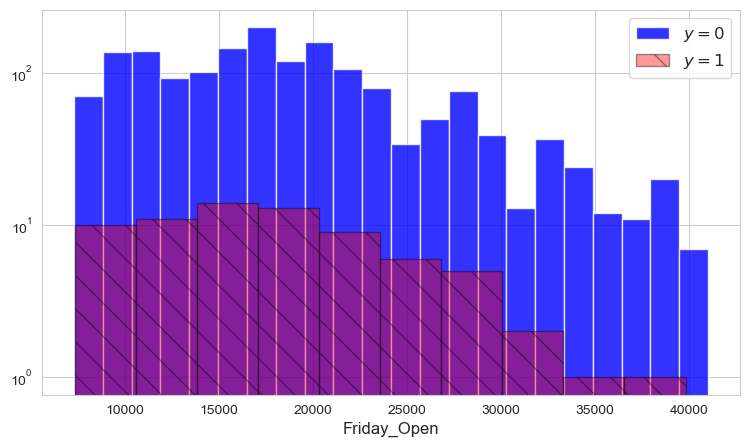

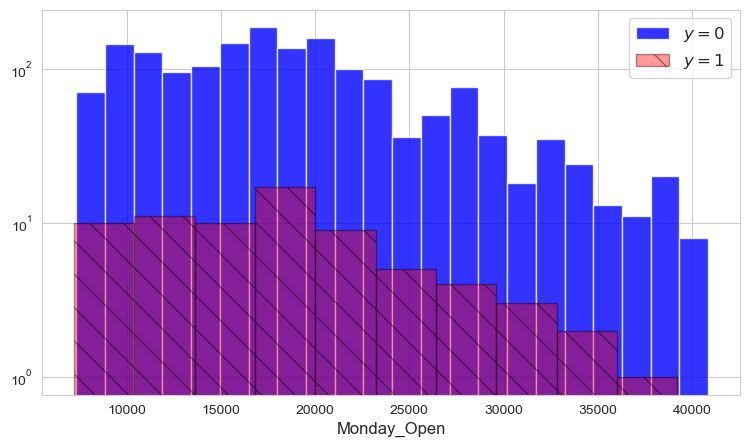

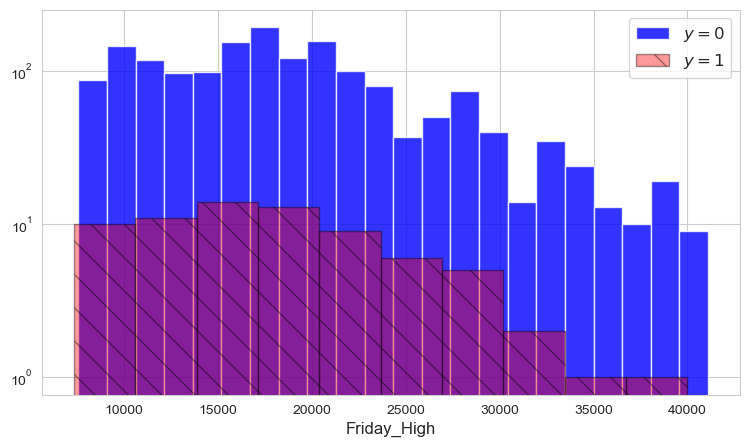

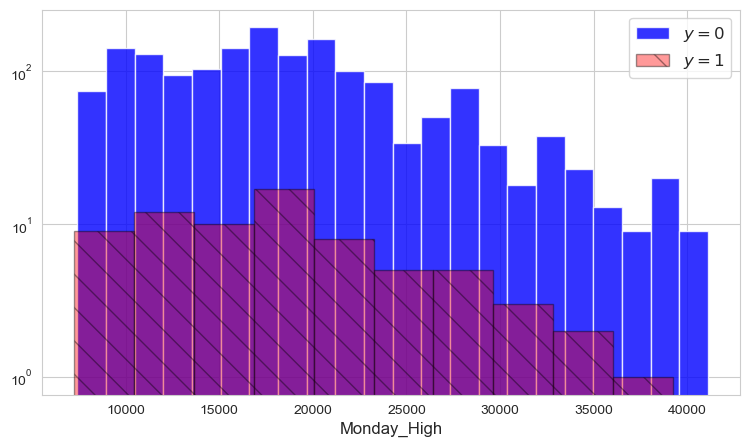

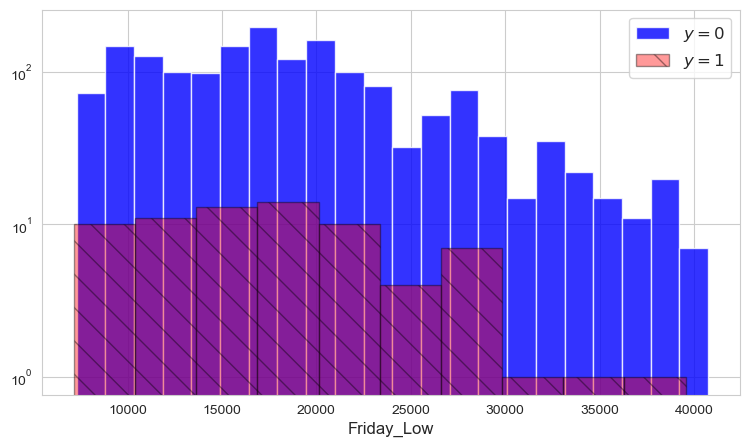

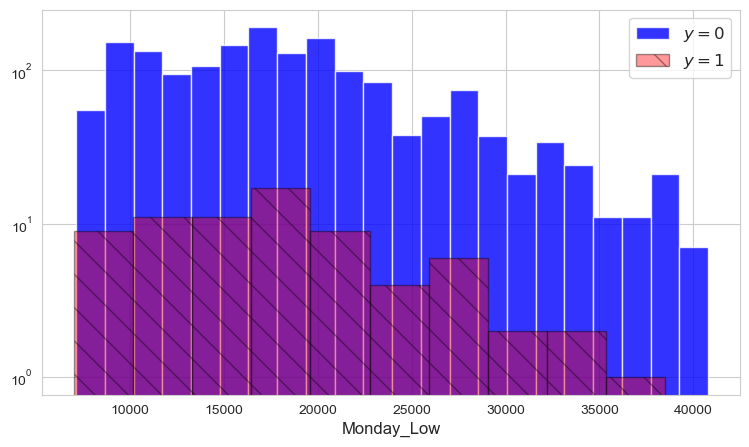

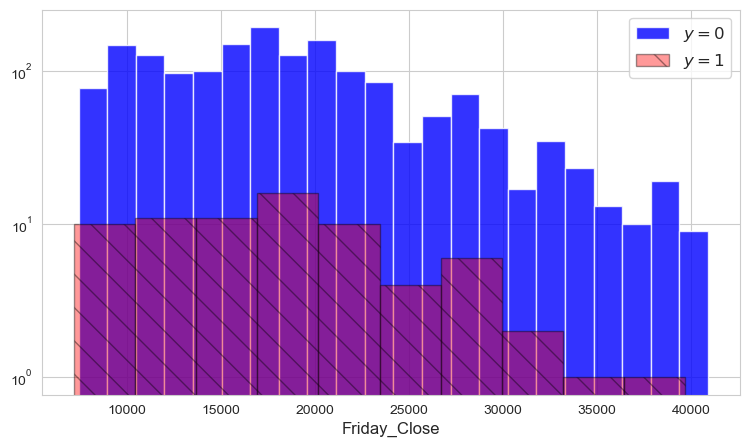

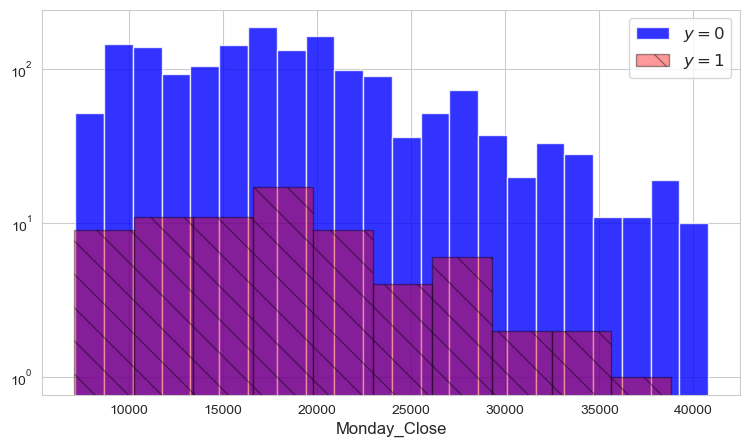

In [51]:
# some histograms but it doesn't reveal much

for metric in metrics:
    plt.figure(figsize=(9,5))

    x_non_dst = nikkei.loc[nikkei.y==0][metric].values
    x_dst = nikkei.loc[nikkei.y==1][metric].values

    n_non = len(x_non_dst)
    n_dst = len(x_dst)

    # non-DST
    q1_non = np.percentile(x_non_dst, 25)
    q3_non = np.percentile(x_non_dst, 75)
    iqr_non = q3_non - q1_non # interquartile range
    h_non = 2*iqr_non/(n_non**(1/3)) # Freedman-Diaconis rule for computing bin width
    k_non = int(np.ceil((max(x_non_dst)-min(x_non_dst))/h_non)) # number of bins

    # DST
    q1_dst = np.percentile(x_dst, 25)
    q3_dst = np.percentile(x_dst, 75)
    iqr_dst = q3_dst - q1_dst # interquartile range
    h_dst = 2*iqr_dst/(n_dst**(1/3)) # Freedman-Diaconis rule for computing bin width
    k_dst = int(np.ceil((max(x_dst)-min(x_dst))/h_dst)) # number of bins


    plt.hist(x_non_dst,log=True,
                color='blue',
                alpha=.8,
                label="$y=0$", bins = k_non)

    plt.hist(x_dst, log=True,
                color='red',
                alpha=.4,
                hatch = '\\',
                edgecolor='black',
                label="$y=1$")

    plt.xlabel(metric, fontsize=12)
    plt.legend(fontsize=12)

    plt.show()

In [52]:
nikkei['diff_fomc'] = (nikkei['Friday_Open']-nikkei['Monday_Close'])/nikkei['Friday_Open']

In [71]:
nikkei['diff_fcmo'] = (nikkei['Friday_Close']-nikkei['Monday_Open'])/nikkei['Friday_Close']

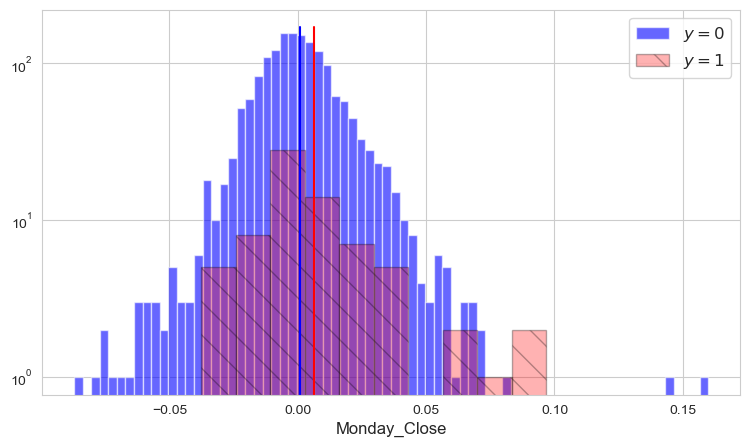

In [62]:

plt.figure(figsize=(9,5))

x_non_dst = nikkei.loc[nikkei.y==0]['diff_fomc'].values
x_dst = nikkei.loc[nikkei.y==1]['diff_fomc'].values

mean_non_dst=np.mean(x_non_dst)
mean_dst=np.mean(x_dst)

n_non = len(x_non_dst)
n_dst = len(x_dst)

# non-DST
q1_non = np.percentile(x_non_dst, 25)
q3_non = np.percentile(x_non_dst, 75)
iqr_non = q3_non - q1_non # interquartile range
h_non = 2*iqr_non/(n_non**(1/3)) # Freedman-Diaconis rule for computing bin width
k_non = int(np.ceil((max(x_non_dst)-min(x_non_dst))/h_non)) # number of bins

# DST
q1_dst = np.percentile(x_dst, 25)
q3_dst = np.percentile(x_dst, 75)
iqr_dst = q3_dst - q1_dst # interquartile range
h_dst = 2*iqr_dst/(n_dst**(1/3)) # Freedman-Diaconis rule for computing bin width
k_dst = int(np.ceil((max(x_dst)-min(x_dst))/h_dst)) # number of bins


plt.hist(x_non_dst,log=True,
            color='blue',
            alpha=.6,
            label="$y=0$", bins = k_non)

plt.hist(x_dst, log=True,
            color='red',
            alpha=.3,
            hatch = '\\',
            edgecolor='black',
            label="$y=1$")

plt.plot([mean_non_dst,mean_non_dst],[0,170], color='b')
plt.plot([mean_dst,mean_dst],[0,170], color='r')

plt.xlabel(metric, fontsize=12)
plt.legend(fontsize=12)

plt.show()

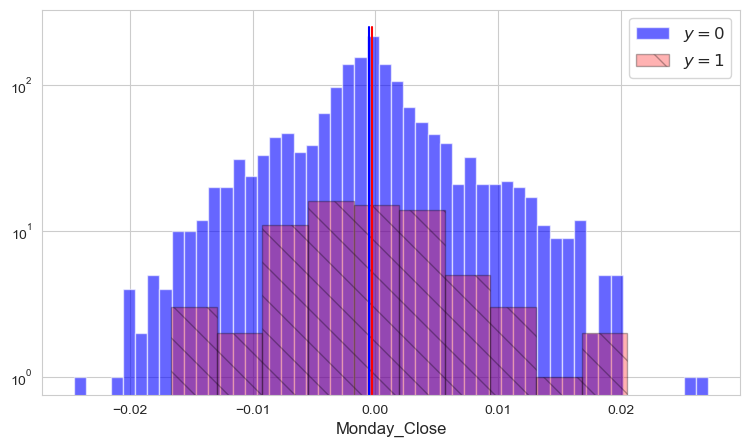

In [74]:

plt.figure(figsize=(9,5))

x_non_dst = nikkei.loc[nikkei.y==0]['diff_fcmo'].values
x_dst = nikkei.loc[nikkei.y==1]['diff_fcmo'].values

mean_non_dst=np.mean(x_non_dst)
mean_dst=np.mean(x_dst)

n_non = len(x_non_dst)
n_dst = len(x_dst)

# non-DST
q1_non = np.percentile(x_non_dst, 25)
q3_non = np.percentile(x_non_dst, 75)
iqr_non = q3_non - q1_non # interquartile range
h_non = 2*iqr_non/(n_non**(1/3)) # Freedman-Diaconis rule for computing bin width
k_non = int(np.ceil((max(x_non_dst)-min(x_non_dst))/h_non)) # number of bins

# DST
q1_dst = np.percentile(x_dst, 25)
q3_dst = np.percentile(x_dst, 75)
iqr_dst = q3_dst - q1_dst # interquartile range
h_dst = 2*iqr_dst/(n_dst**(1/3)) # Freedman-Diaconis rule for computing bin width
k_dst = int(np.ceil((max(x_dst)-min(x_dst))/h_dst)) # number of bins


plt.hist(x_non_dst,log=True,
            color='blue',
            alpha=.6,
            label="$y=0$", bins = k_non)

plt.hist(x_dst, log=True,
            color='red',
            alpha=.3,
            hatch = '\\',
            edgecolor='black',
            label="$y=1$")

plt.plot([mean_non_dst,mean_non_dst],[0,250], color='b')
plt.plot([mean_dst,mean_dst],[0,250], color='r')

plt.xlabel(metric, fontsize=12)
plt.legend(fontsize=12)

plt.show()

In [87]:
metrics = list(nikkei.columns[2:])


In [88]:
metrics.remove('y')

In [89]:
metrics

['Friday_Open',
 'Monday_Open',
 'Friday_High',
 'Monday_High',
 'Friday_Low',
 'Monday_Low',
 'Friday_Close',
 'Monday_Close',
 'diff_fomc',
 'diff_fcmo']

In [90]:
metrics[-4:]

['Friday_Close', 'Monday_Close', 'diff_fomc', 'diff_fcmo']

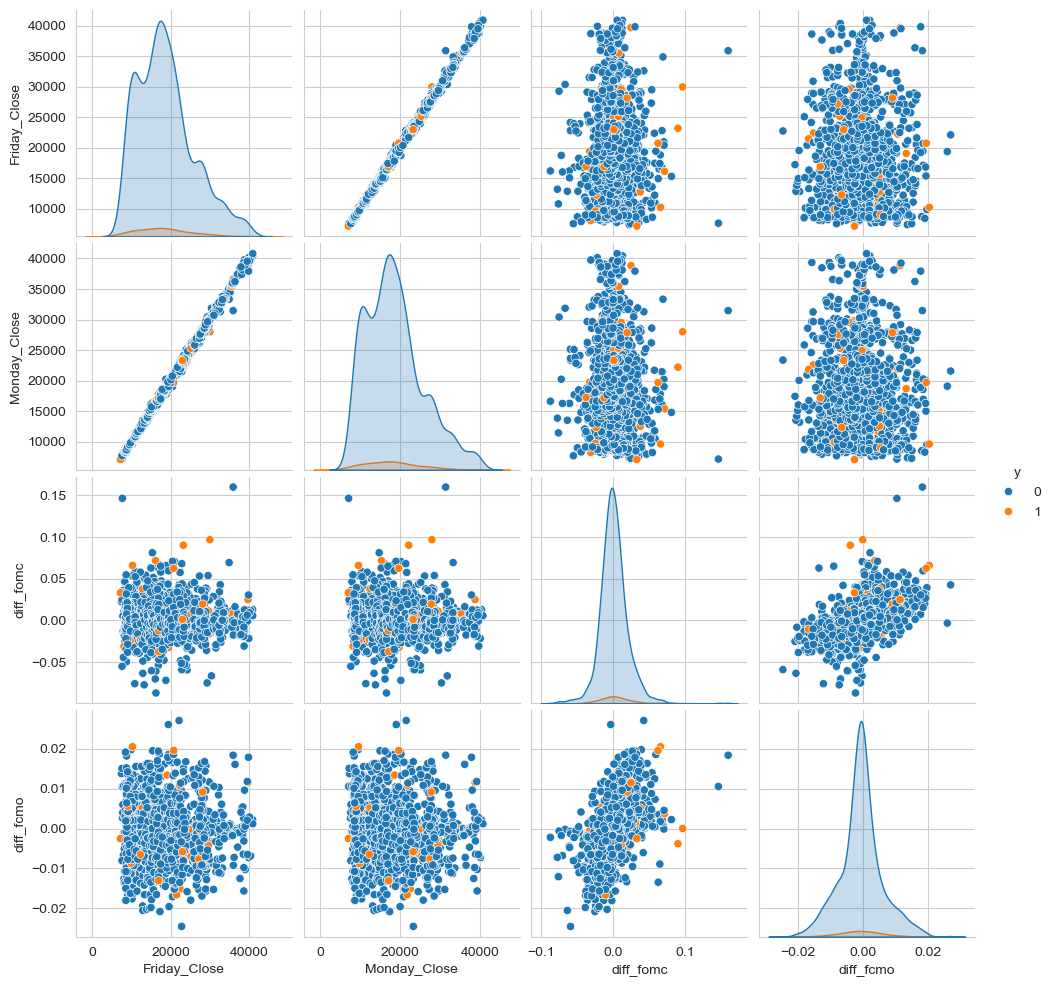

In [91]:
sns.pairplot(data = nikkei,
                x_vars = metrics[-4:],
                y_vars = metrics[-4:],
                hue = 'y')

plt.show()

In [98]:
metrics=metrics[:-2]

In [99]:
metrics

['Friday_Open',
 'Monday_Open',
 'Friday_High',
 'Monday_High',
 'Friday_Low',
 'Monday_Low',
 'Friday_Close',
 'Monday_Close']

## Classifiers

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
nikkei_train, nikkei_test = train_test_split(nikkei,test_size=0.1,stratify=nikkei['y'])

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold

Train on all metrics

In [104]:
## Make your kfold object
n_splits = 5

kfold = KFold(n_splits=n_splits)

In [105]:
## Fill in the range you want to try for k; say from 1 neighbor to 10
ks = range(1,11)

## Make an array to hold the accuracies
k_all_accs = np.zeros((n_splits,len(ks)))

i = 0
for train_index, test_index in kfold.split(nikkei_train):
    ## Get the train and holdout sets
    nikkei_tt = nikkei_train.iloc[train_index]
    nikkei_ho = nikkei_train.iloc[test_index]
    
    ## Loop through the different ks
    j = 0
    for k in ks:
        ## Make the model object
        knn = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=k))])
        
        ## Fit the model
        knn.fit(nikkei_tt[metrics],nikkei_tt['y'])
        
        ## Make your prediction
        pred = knn.predict(nikkei_ho[metrics])
        
        ## Record the accuracy on the holdout set
        k_all_accs[i,j] = accuracy_score(nikkei_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

In [106]:
nikkei_train['y'].value_counts(normalize=True)

y
0    0.958782
1    0.041218
Name: proportion, dtype: float64

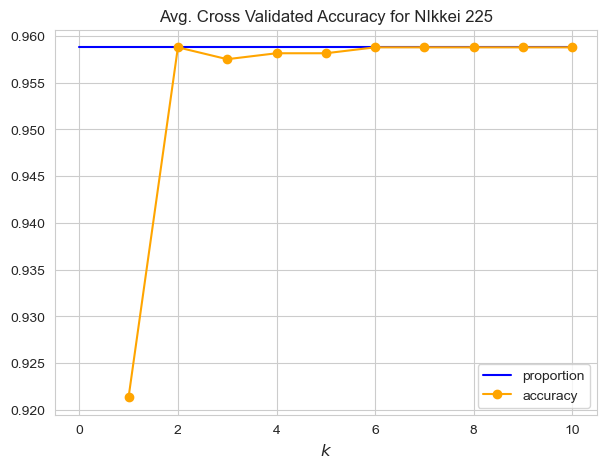

In [108]:
## Plots the accuracies as a function of k
plt.figure(figsize=(7,5))

plt.plot([0,10],[0.958782,0.958782],label='proportion',color='b')

plt.plot(ks, 
         np.mean(k_all_accs, axis=0),
         '-o',color='orange',label='accuracy')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.title("Avg. Cross Validated Accuracy for NIkkei 225", fontsize=12)

plt.legend()
plt.show()

Train on just the differences

In [111]:
## Fill in the range you want to try for k; say from 1 neighbor to 10
ks = range(1,11)

## Make an array to hold the accuracies
k_all_accs = np.zeros((n_splits,len(ks)))

i = 0
for train_index, test_index in kfold.split(nikkei_train):
    ## Get the train and holdout sets
    nikkei_tt = nikkei_train.iloc[train_index]
    nikkei_ho = nikkei_train.iloc[test_index]
    
    ## Loop through the different ks
    j = 0
    for k in ks:
        ## Make the model object
        knn = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=k))])
        
        ## Fit the model
        knn.fit(nikkei_tt[['diff_fomc']],nikkei_tt['y'])
        
        ## Make your prediction
        pred = knn.predict(nikkei_ho[['diff_fomc']])
        
        ## Record the accuracy on the holdout set
        k_all_accs[i,j] = accuracy_score(nikkei_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

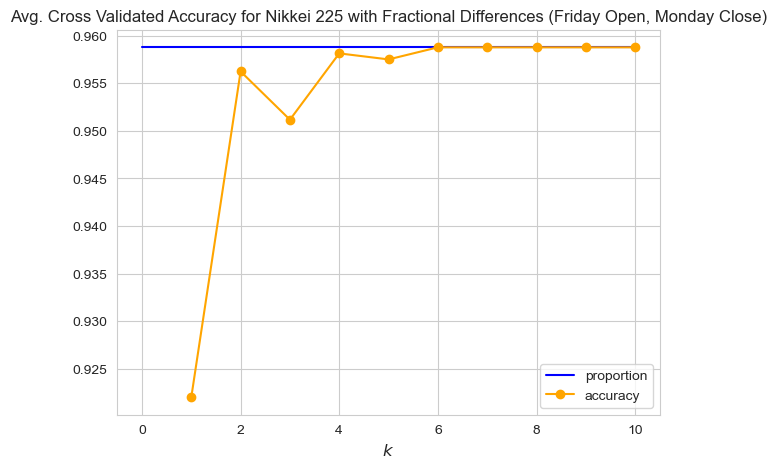

In [112]:
## Plots the accuracies as a function of k
plt.figure(figsize=(7,5))

plt.plot([0,10],[0.958782,0.958782],label='proportion',color='b')

plt.plot(ks, 
         np.mean(k_all_accs, axis=0),
         '-o',color='orange',label='accuracy')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.title("Avg. Cross Validated Accuracy for Nikkei 225 with Fractional Differences (Friday Open, Monday Close)", fontsize=12)

plt.legend()
plt.show()

Try balanced random forest

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from tree_helpers import SkNode, traversable_nodes

In [113]:
tree = DecisionTreeClassifier(
    #max_depth = 10, 
    min_samples_leaf = 5, # minimum number of samples in each leaf, to prevent overfitting
    class_weight='balanced')

rf = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 3, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 2, 
    bootstrap= True, # sampling with replacement
    max_samples = 300, # number of training samples selected with replacement to build tree
    class_weight='balanced'
    )


et = ExtraTreesClassifier(
    n_estimators = 500, 
    #max_depth = 10, 
    min_samples_leaf = 5, 
    max_features = 2, 
    #bootstrap= True, 
    #max_samples = 500, 
    class_weight='balanced'
    )

In [114]:
tree.fit(nikkei_train[metrics],nikkei_train['y'])
rf.fit(nikkei_train[metrics],nikkei_train['y'])
et.fit(nikkei_train[metrics],nikkei_train['y'])

ExtraTreesClassifier(class_weight='balanced', max_features=2,
                     min_samples_leaf=5, n_estimators=500)

In [115]:
tree_preds=tree.predict(nikkei_test[metrics])

confusion_matrix(nikkei_test['y'], tree_preds)

array([[151,  18],
       [  6,   1]])

In [116]:
rf_preds=rf.predict(nikkei_test[metrics])

confusion_matrix(nikkei_test['y'], rf_preds)

array([[169,   0],
       [  7,   0]])

In [117]:
et_preds=et.predict(nikkei_test[metrics])

confusion_matrix(nikkei_test['y'], et_preds)

array([[154,  15],
       [  5,   2]])

In [118]:
accs = [accuracy_score(nikkei_test['y'], tree_preds),  accuracy_score(nikkei_test['y'], rf_preds), accuracy_score(nikkei_test['y'], et_preds)]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.863636
rf,0.960227
et,0.886364


In [119]:
prec= [precision_score(nikkei_test['y'], tree_preds),  precision_score(nikkei_test['y'], rf_preds), precision_score(nikkei_test['y'], et_preds)]
pd.DataFrame(prec, index= ['tree', 'rf', 'et'], columns = ['precision'])

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision
tree,0.052632
rf,0.000000
et,0.117647


In [120]:
rec = [recall_score(nikkei_test['y'], tree_preds),  recall_score(nikkei_test['y'], rf_preds), recall_score(nikkei_test['y'], et_preds)]
pd.DataFrame(rec, index= ['tree', 'rf', 'et'], columns = ['recall'])

,recall
tree,0.142857
rf,0.000000
et,0.285714


In [121]:
tree.fit(nikkei_train[['diff_fomc']],nikkei_train['y'])
rf.fit(nikkei_train[['diff_fomc']],nikkei_train['y'])
et.fit(nikkei_train[['diff_fomc']],nikkei_train['y'])

ExtraTreesClassifier(class_weight='balanced', max_features=2,
                     min_samples_leaf=5, n_estimators=500)

In [123]:
tree_preds=tree.predict(nikkei_test[['diff_fomc']])

confusion_matrix(nikkei_test['y'], tree_preds)

array([[143,  26],
       [  5,   2]])

In [124]:
rf_preds=rf.predict(nikkei_test[['diff_fomc']])

confusion_matrix(nikkei_test['y'], rf_preds)

array([[168,   1],
       [  7,   0]])

In [125]:
et_preds=et.predict(nikkei_test[['diff_fomc']])

confusion_matrix(nikkei_test['y'], et_preds)

array([[132,  37],
       [  4,   3]])

In [126]:
accs = [accuracy_score(nikkei_test['y'], tree_preds),  accuracy_score(nikkei_test['y'], rf_preds), accuracy_score(nikkei_test['y'], et_preds)]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.823864
rf,0.954545
et,0.767045


In [127]:
prec= [precision_score(nikkei_test['y'], tree_preds),  precision_score(nikkei_test['y'], rf_preds), precision_score(nikkei_test['y'], et_preds)]
pd.DataFrame(prec, index= ['tree', 'rf', 'et'], columns = ['precision'])

,precision
tree,0.071429
rf,0.000000
et,0.075000


In [128]:
rec = [recall_score(nikkei_test['y'], tree_preds),  recall_score(nikkei_test['y'], rf_preds), recall_score(nikkei_test['y'], et_preds)]
pd.DataFrame(rec, index= ['tree', 'rf', 'et'], columns = ['recall'])

,recall
tree,0.285714
rf,0.000000
et,0.428571
